In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os import path
import zipfile


In [2]:
if not path.exists('./goodreads10k/ratings.csv'):
    with zipfile.ZipFile("./goodreads10k/goodreads10k.zip","r") as zip_ref:
        zip_ref.extractall("./goodreads10k")

In [3]:
import pandas as pd

In [4]:
books = pd.read_csv('./goodreads10k/books.csv')
ratings = pd.read_csv('./goodreads10k/ratings.csv')

In [5]:
ratings.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [6]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import Reader


In [62]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(ratings[['user_id', 'book_id', 'rating']], reader)

{'test_rmse': array([0.84913762, 0.84973109]),
 'test_mae': array([0.66601425, 0.66636881]),
 'fit_time': (9.935952186584473, 13.520477056503296),
 'test_time': (6.574236631393433, 5.467742919921875)}

In [74]:
data = Dataset.load_from_df(ratings[['user_id', 'book_id', 'rating']], reader)

algo = SVD(n_factors=5)
algo.fit(data.build_full_trainset())

In [75]:
algo.qi.shape

(10000, 50)

In [86]:
import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=3000 ).fit_transform(algo.qi)
X_embedded.shape

(10000, 2)

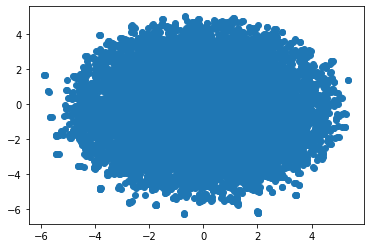

In [87]:
import matplotlib.pyplot as plt

plt.scatter(X_embedded[:, 0], X_embedded[:, 1])

In [88]:
tsne_results = X_embedded

In [89]:
from goodreads10k.categories import get_categories
book_categories = get_categories()

ImportError: cannot import name 'get_categories' from 'goodreads10k.categories' (c:\pwr\ONOS\P4\Books-ONOS\goodreads10k\categories.py)

In [ ]:
def get_category(book_id):
    try:
        category = book_categories[book_id]
    except:
        category = 'other'

    return category

df_combine = pd.DataFrame(books[['id', 'book_id', 'title']])
df_combine.columns = ['id', 'book_id', 'title']
df_combine['category'] = df_combine['book_id'].apply(lambda bid: get_category(bid))
df_combine['x-tsne'] = tsne_results[:,0]
df_combine['y-tsne'] = tsne_results[:,1]  
df_combine

In [91]:
from bokeh.plotting import figure, show, output_notebook, save
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource
from bokeh.transform import factor_cmap
from bokeh.palettes import Category20b

output_notebook()

source = ColumnDataSource(dict(
    x=df_combine['x-tsne'],
    y=df_combine['y-tsne'],
    title= df_combine['title'],
    #fill_color=colors,
    legend=df_combine['category']
))

title = 'PCA visualization of embeddings'

plot_lda = figure(plot_width=2000, plot_height=1000,
                     title='title', tools="pan,wheel_zoom,box_zoom,reset,hover",
                     x_axis_type=None, y_axis_type=None, min_border=1)

plot_lda.scatter(x='x', y='y',source=source,
                alpha=0.8, size=10, fill_color=factor_cmap('legend', palette=Category20b[20], factors=df_combine.category.unique()), legend='legend')

# hover tools
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "Title: @title"}

show(plot_lda)

Loading BokehJS ...